# Hello World! with PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline

# Helper functions and contants

In [2]:
NUM_EPOCH = 3
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_NUM_CHANNELS = 1
BATCH_SIZE = 64
LOG_EVERY = 100

USE_LOGSOFTMAX = False
USE_MNIST = False
USE_SGD = False
MNIST_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
FASHION_MNIST_CLASSES = ["T-shirt/top",
                         "Trouser",
                         "Pullover",
                         "Dress",
                         "Coat",
                         "Sandal",
                         "Shirt",
                         "Sneaker",
                         "Bag",
                         "Ankle Boot"]

CHECKPOINT_NAME = "saved_models/lenet_check.pth"

In [3]:
def view_img_prob(img, prob, y, classes):
    """Show an image and associated probability distribution"""
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)

    ax1.imshow(img.numpy().squeeze(), cmap="gray")
    ax1.axis('off')
    ax2.barh(np.arange(len(classes)), prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(classes)))
    ax2.set_yticklabels(classes)
    ax2.set_title('Probabilities')
    ax2.set_xlim(0, 1.0)
    plt.tight_layout()
    
    print("Prediction: {} - Actual: {}".format(classes[prob.argmax()], classes[y.numpy()]))

In [4]:
def predict_one(model, loader):
    """Use the model to predict the class of the first image returned by the dataloader"""
    # Grab the first batch
    load_iter = iter(loader)
    X, y = load_iter.next()

    # Predict
    with torch.no_grad():
        if USE_LOGSOFTMAX:
            logsoftmax = model.forward(X)
            softmax = torch.exp(logsoftmax)
        else:
            logits = model.forward(X)
            softmax = F.softmax(logits, dim=-1)
    
    softmax = softmax.numpy()

    # Show one image
    print("Softmax: {}".format(softmax[0]))
    view_img_prob(X[0], softmax[0], y[0], classes=CLASSES)

# Create dataloaders
Data is loaded if not already present.

In [5]:
# Prepare image pre-processing
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))
                           ])

# Create the training data class
if USE_MNIST:
    train = datasets.MNIST("MNIST", download=True, train=True, transform=trans)
    test = datasets.MNIST("MNIST", download=True, train=False, transform=trans)    
    CLASSES = MNIST_CLASSES
else:
    train = datasets.FashionMNIST("FashionMNIST", download=True, train=True, transform=trans)
    test = datasets.FashionMNIST("FashionMNIST", download=True, train=False, transform=trans)    
    CLASSES = FASHION_MNIST_CLASSES
    
# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# Show an image
Simply use the first image just to have a look.

Class: Ankle Boot


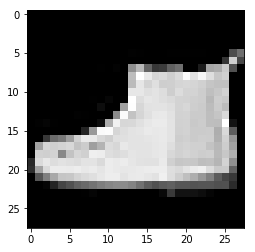

In [6]:
train_iter = iter(train_loader)
imgs, labels = train_iter.next()
plt.imshow(imgs[0].numpy().squeeze(), cmap="gray")
print("Class: {}".format(CLASSES[labels[0]]))

# Build the network
Not quite exactly the same as in the paper, but close enough. Does not use any special weight initalizers, just whatever PyTorch uses by default.

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)

        return x
    
class LeNet5(nn.Module):
    def __init__(self, num_channels):
        super(LeNet5, self).__init__()
        
        self.c1 = nn.Conv2d(in_channels=num_channels, out_channels=6, kernel_size=(5,5), padding=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5))
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.the_output = nn.Linear(in_features=84, out_features=10)        

    def forward(self, x):
        # C1, S2
        x = F.tanh(self.c1(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))

        # C3, S4
        x = F.tanh(self.c3(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        
        # C5
        x = self.c5(x)
        x = F.tanh(x)
        
        # Flatten
        x = Flatten().forward(x)

        # F6
        x = F.tanh(self.f6(x))
        
        # OUTPUT
        x = self.the_output(x)
        
        # Either return the logits or the logsoftmax. In case of the former apply softmax
        # to the logits to get the pobability distribution during inference. For the latter
        # raise exp to the power of the logits
        if USE_LOGSOFTMAX:
            x = F.log_softmax(x, dim=-1)
        
        return x

# Show the trainable layers

In [8]:
lenet = LeNet5(IMG_NUM_CHANNELS)
lenet

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (the_output): Linear(in_features=84, out_features=10, bias=True)
)

# Predictions without training
Pretty much a uniform distribution.

Softmax: [0.10368662 0.09822106 0.10025024 0.09244755 0.10339945 0.09585794
 0.10259561 0.1097284  0.09002805 0.10378511]
Prediction: Sneaker - Actual: Dress


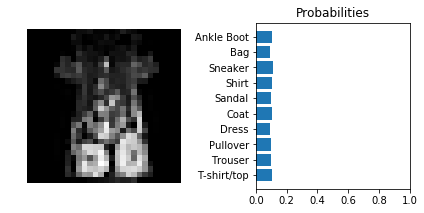

In [9]:
predict_one(lenet, train_loader)

# Train the model

In [10]:
def validate(model, val_loader):
    """Calculate loss and accuracy of the model on the entire validation set"""
    model.eval()
    loss = 0
    count = 0
    correct = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            output = model.forward(X_val)
            loss += crit(output, y_val)

            if USE_LOGSOFTMAX:
                pred = torch.exp(output)
            else:
                pred = F.softmax(output, dim=-1)

            # Compare the actual labels to the argmax of the predictions
            count += len(X_val)
            correct += (y_val == pred.max(dim=-1)[1]).sum().item()

    model.train()

    return loss/len(val_loader), correct/count

In [11]:
def train_model(model, crit, opt, trn_loader, val_loader):
    """Train the model using the provided loss function, optimiser, training set
    data loader and validation set data loader"""
    start_time = time.time()
    model.zero_grad()

    for e in range(NUM_EPOCH):
        total_correct = 0
        total_count = 0
        total_loss = 0
        run_loss = 0
        batch = 0
        
        print("\nEpoch: {}/{}".format(e+1, NUM_EPOCH))
        print("=======================")

        for batch, (X, y) in enumerate(trn_loader, 0):
            model.train()
            opt.zero_grad()

            # Forward, backward and optimise
            output = model.forward(X)
            loss = crit(output, y)
            loss.backward()
            opt.step()

            # Convert to probabilities
            if USE_LOGSOFTMAX:
                pred = torch.exp(output)
            else:
                pred = F.softmax(output, dim=-1)
            
            # Keep track of metrics
            correct = (y == pred.max(dim=-1)[1]).sum().item()
            total_count += len(X)
            total_correct += correct
            total_loss += loss
            run_loss += loss
            
            if batch % LOG_EVERY == (LOG_EVERY-1):
                val_loss, val_acc = validate(model, val_loader)

                # Print batch stats
                print("Batch {:04d}/{:04d} - Trn_loss: {:.4f}, Trn_acc: {:6.2f}% -".format(batch+1, len(trn_loader), run_loss/LOG_EVERY, 100*(correct/len(X))),
                      "Val_loss: {:.4f}, Val_acc: {:6.2f}%".format(val_loss, 100*val_acc))
                
                run_loss = 0

        # Print epoch stats
        val_loss, val_acc = validate(model, val_loader)
        print("\n                  Trn_loss: {:.4f}, Trn_acc: {:6.2f}% -".format(total_loss/len(trn_loader), 100*(total_correct/total_count)),
              "Val_loss: {:.4f}, Val_acc: {:6.2f}%".format(val_loss, 100*val_acc))

    print("\nTraining complete, elapsed time: {:2f}min.".format((time.time() - start_time)/60))

In [12]:
if USE_LOGSOFTMAX:
    crit = nn.NLLoss()
else:
    crit = nn.CrossEntropyLoss()

if USE_SGD:
    opt = optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9)
else:
    opt = optim.Adam(lenet.parameters(), lr=0.001)

train_model(lenet, crit, opt, train_loader, test_loader)


Epoch: 1/3
Batch 0100/0938 - Trn_loss: 1.0716, Trn_acc:  73.44% - Val_loss: 0.7257, Val_acc:  72.10%
Batch 0200/0938 - Trn_loss: 0.6185, Trn_acc:  84.38% - Val_loss: 0.6048, Val_acc:  76.92%
Batch 0300/0938 - Trn_loss: 0.5414, Trn_acc:  81.25% - Val_loss: 0.5328, Val_acc:  80.45%
Batch 0400/0938 - Trn_loss: 0.4924, Trn_acc:  85.94% - Val_loss: 0.4972, Val_acc:  81.88%
Batch 0500/0938 - Trn_loss: 0.4607, Trn_acc:  84.38% - Val_loss: 0.4853, Val_acc:  82.38%
Batch 0600/0938 - Trn_loss: 0.4410, Trn_acc:  78.12% - Val_loss: 0.4439, Val_acc:  83.70%
Batch 0700/0938 - Trn_loss: 0.4277, Trn_acc:  87.50% - Val_loss: 0.4154, Val_acc:  84.78%
Batch 0800/0938 - Trn_loss: 0.4218, Trn_acc:  93.75% - Val_loss: 0.4016, Val_acc:  85.46%
Batch 0900/0938 - Trn_loss: 0.3876, Trn_acc:  93.75% - Val_loss: 0.4119, Val_acc:  85.11%

                  Trn_loss: 0.5339, Trn_acc:  80.97% - Val_loss: 0.3895, Val_acc:  85.93%

Epoch: 2/3
Batch 0100/0938 - Trn_loss: 0.3628, Trn_acc:  84.38% - Val_loss: 0.4117, Va

# Apply the trained model to a test set image

Softmax: [1.0225976e-05 2.0458156e-06 1.4202833e-05 4.5683528e-06 1.0042678e-05
 1.8885045e-04 2.3425357e-05 1.0622413e-02 9.7373697e-05 9.8902684e-01]
Prediction: Ankle Boot - Actual: Ankle Boot


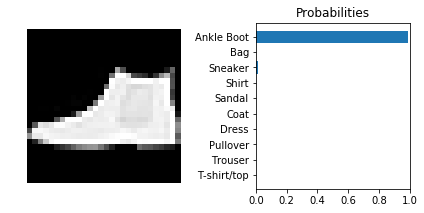

In [13]:
predict_one(lenet, test_loader)

# Save and load

Softmax: [1.4386135e-03 5.1920488e-05 6.3546978e-02 8.1356114e-04 7.1722269e-02
 5.6762688e-05 8.6147857e-01 1.5759648e-05 8.1666780e-04 5.8902671e-05]
Prediction: Shirt - Actual: Shirt


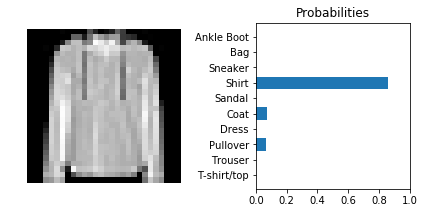

In [14]:
torch.save(lenet.state_dict(), CHECKPOINT_NAME)
state = torch.load(CHECKPOINT_NAME)
lenet_new = LeNet5(IMG_NUM_CHANNELS)
lenet_new.load_state_dict(state)
predict_one(lenet_new, test_loader)

# End of notebook